# train

In [1]:
import yaml
import os

with open("./config.yaml", 'rb') as f:
    config = yaml.load(f)

<ipython-input-1-1499ab5789c7>:5: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [2]:
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
os.makedirs(OUTPUT_ROOT, exist_ok=True)

## load library

In [3]:
# python default library
import os
import shutil
import datetime
import sys
import pickle

# general analysis tool-kit
import numpy as np
import pandas as pd
#from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# pytorch
import torch
from torch import optim, nn
from torch.utils.tensorboard import SummaryWriter

#from torchsummary import summary

# etc
import yaml
yaml.warnings({'YAMLLoadWarning': False})

# original library
sys.path.append('/home/hiroki/research/dcase2021_task2/src/functions')
import common as com
import pytorch_modeler as modeler
from pytorch_model import Conditional_VAE as Model
#from pytorch_utils import filtered_load_model
#import models

import librosa
import IPython
import librosa.display

## load config and set logger

In [4]:
log_file = config['IO_OPTION']['OUTPUT_ROOT']+'/train_{0}.log'.format(datetime.date.today())
logger = com.setup_logger(log_file, '00_train.py')

## Setting

In [5]:
# Setting seed
modeler.set_seed(777)

In [6]:
############################################################################
# Setting I/O path
############################################################################
# input dirs
INPUT_ROOT = config['IO_OPTION']['INPUT_ROOT']
#dev_dir = INPUT_ROOT + "/dev_data"
#add_dev_dir = INPUT_ROOT + "/add_dev_data"
# machine type
machine_types = ['ToyCar', 'gearbox', 'valve', 'ToyTrain', 'pump', 'fan', 'slider']
# output dirs
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
MODEL_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/models'
TB_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/tb'
OUT_FEATURE_DIR = OUTPUT_ROOT + '/extraction_features'
OUT_SCORE_DIR = OUTPUT_ROOT + '/score'
OUT_PRED_DIR = OUTPUT_ROOT + '/pred'
#os.makedirs(OUTPUT_ROOT, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(TB_DIR, exist_ok=True)
os.makedirs(OUT_FEATURE_DIR, exist_ok=True)
os.makedirs(OUT_SCORE_DIR, exist_ok=True)
os.makedirs(OUT_PRED_DIR, exist_ok=True)
# copy config
shutil.copy('./config.yaml', OUTPUT_ROOT)

'/media/hiroki/HDD1TB/research/dcase2021_task2/output/ID_Conditional_VAE/CVAE_ex3/config.yaml'

In [7]:
torch.cuda.is_available()

True

## training

In [8]:
#############################################################################
# run
#############################################################################
def run(machine_type):
    com.tic()
    
    logger.info('TARGET MACHINE_TYPE: {0}'.format(machine_type))
    logger.info('MAKE DATA_LOADER')
    # dataloader
    ext_data = pd.read_pickle(f'{INPUT_ROOT}/{machine_type}_features.pkl')
    dataloaders_dict = modeler.make_dataloader(ext_data)
    # define writer for tensorbord
    os.makedirs(TB_DIR+'/'+machine_type, exist_ok=True)
    tb_log_dir = TB_DIR + '/' + machine_type
    writer = SummaryWriter(log_dir = tb_log_dir)
    # out path
    model_out_path = MODEL_DIR+'/{}_model.pth'.format(machine_type)
    score_out_path = OUT_SCORE_DIR + '/{}_score.csv'.format(machine_type)
    pred_out_path = OUT_PRED_DIR + '/{}_pred.csv'.format(machine_type)
    logger.info('TRAINING')
    # parameter setting
    in_features = ext_data['train']['features'].shape[1]
    mid_size = config['param']['mid_size']
    latent_size = config['param']['latent_size']
    num_classes = 6
    net = Model(in_features, mid_size, latent_size, num_classes)
    optimizer = optim.Adam(net.parameters(), lr=1e-3)
    num_epochs = config['param']['num_epochs']
    #scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e-2, 
    #                                          max_lr=1e-3, epochs=num_epochs, steps_per_epoch=len(dataloaders_dict['train']))
    # training
    output_dicts = modeler.train_net(net, dataloaders_dict, optimizer, num_epochs, writer, model_out_path, score_out_path, pred_out_path)
    
    com.toc()

In [9]:
machine_types

['ToyCar', 'gearbox', 'valve', 'ToyTrain', 'pump', 'fan', 'slider']

2021-04-26 16:13:05,995 - 00_train.py - INFO - TARGET MACHINE_TYPE: valve
2021-04-26 16:13:05,996 - 00_train.py - INFO - MAKE DATA_LOADER
2021-04-26 16:13:06,036 - 00_train.py - INFO - TRAINING


use: cuda:0


2021-04-26 16:13:07,723 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  2.11it/s]
2021-04-26 16:13:08,672 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.60it/s]
2021-04-26 16:13:08,829 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.85it/s]


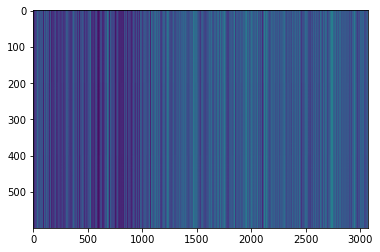

AUC      pAUC
Source_0  0.515400  0.500526
Source_1  0.540600  0.507895
Source_2  0.480000  0.511579
Target_0  0.518900  0.495789
Target_1  0.637300  0.591053
Target_2  0.513050  0.520000
mean      0.534208  0.521140
h_mean    0.530093  0.519323

2021-04-26 16:13:09,881 - pytorch_modeler.py - INFO - epoch:1/300, train_losses:53.477886, val_AUC_hmean:0.530093, val_pAUC_hmean:0.519323, best_flag:True
2021-04-26 16:13:09,882 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  4.88it/s]
2021-04-26 16:13:10,294 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.43it/s]
2021-04-26 16:13:10,450 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.66it/s]
2021-04-26 16:13:10,607 - pytorch_modeler.py - INFO - epoch:2/300, train_losses:16.610029, val_AUC_hmean:0.519700, val_pAUC_hmean:0.507748, best_flag:False
2021-04-26 16:13:10,608 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  4.80it/s]
2021-04-26 16:13:11,028 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.88it/s]
2021-04-26 16:13:11,175 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.92it/s]
2021-04-26 16:13:11,325 -

100%|██████████| 1/1 [00:00<00:00,  7.47it/s]
2021-04-26 16:13:21,998 - pytorch_modeler.py - INFO - epoch:18/300, train_losses:0.472026, val_AUC_hmean:0.507465, val_pAUC_hmean:0.511691, best_flag:False
2021-04-26 16:13:21,999 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  5.20it/s]
2021-04-26 16:13:22,386 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.13it/s]
2021-04-26 16:13:22,545 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.82it/s]
2021-04-26 16:13:22,696 - pytorch_modeler.py - INFO - epoch:19/300, train_losses:0.442296, val_AUC_hmean:0.516374, val_pAUC_hmean:0.509492, best_flag:False
2021-04-26 16:13:22,697 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  5.12it/s]
2021-04-26 16:13:23,090 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.65it/s]
2021-04-26 16:13:23,240 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00

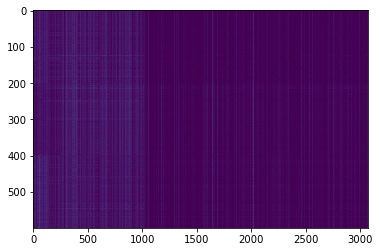

AUC      pAUC
Source_0  0.504300  0.526842
Source_1  0.468600  0.500000
Source_2  0.570700  0.508947
Target_0  0.479200  0.491053
Target_1  0.646000  0.623158
Target_2  0.489100  0.520000
mean      0.526317  0.528333
h_mean    0.519545  0.525063

2021-04-26 16:13:25,692 - pytorch_modeler.py - INFO - epoch:22/300, train_losses:0.386076, val_AUC_hmean:0.519545, val_pAUC_hmean:0.525063, best_flag:True
2021-04-26 16:13:25,693 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  5.00it/s]
2021-04-26 16:13:26,095 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.58it/s]
2021-04-26 16:13:26,249 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.34it/s]
2021-04-26 16:13:26,412 - pytorch_modeler.py - INFO - epoch:23/300, train_losses:0.394133, val_AUC_hmean:0.519610, val_pAUC_hmean:0.523576, best_flag:False
2021-04-26 16:13:26,413 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  5.11it/s]
2021-04-26 16:13:26,807 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.36it/s]
2021-04-26 16:13:26,965 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.53it/s]
2021-04-26 16:13:27,120 -

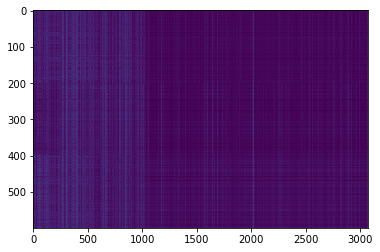

AUC      pAUC
Source_0  0.509000  0.518421
Source_1  0.486900  0.506842
Source_2  0.577000  0.515789
Target_0  0.483900  0.497895
Target_1  0.675000  0.627895
Target_2  0.498000  0.510000
mean      0.538300  0.529474
h_mean    0.530616  0.526197

2021-04-26 16:13:28,698 - pytorch_modeler.py - INFO - epoch:25/300, train_losses:0.364741, val_AUC_hmean:0.530616, val_pAUC_hmean:0.526197, best_flag:True
2021-04-26 16:13:28,699 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  5.24it/s]
2021-04-26 16:13:29,083 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.70it/s]
2021-04-26 16:13:29,231 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.60it/s]
2021-04-26 16:13:29,387 - pytorch_modeler.py - INFO - epoch:26/300, train_losses:0.352180, val_AUC_hmean:0.529242, val_pAUC_hmean:0.524729, best_flag:False
2021-04-26 16:13:29,388 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  5.11it/s]
2021-04-26 16:13:29,781 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.88it/s]
2021-04-26 16:13:29,927 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.84it/s]
2021-04-26 16:13:30,077 -

100%|██████████| 1/1 [00:00<00:00,  7.72it/s]
2021-04-26 16:13:40,836 - pytorch_modeler.py - INFO - epoch:42/300, train_losses:0.291779, val_AUC_hmean:0.584200, val_pAUC_hmean:0.518577, best_flag:False
2021-04-26 16:13:40,837 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  4.71it/s]
2021-04-26 16:13:41,264 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.29it/s]
2021-04-26 16:13:41,422 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.32it/s]
2021-04-26 16:13:41,582 - pytorch_modeler.py - INFO - epoch:43/300, train_losses:0.292781, val_AUC_hmean:0.567311, val_pAUC_hmean:0.515388, best_flag:False
2021-04-26 16:13:41,583 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  5.11it/s]
2021-04-26 16:13:41,976 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.66it/s]
2021-04-26 16:13:42,125 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00

100%|██████████| 1/1 [00:00<00:00,  7.39it/s]
2021-04-26 16:13:53,061 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.23it/s]
2021-04-26 16:13:53,221 - pytorch_modeler.py - INFO - epoch:59/300, train_losses:0.262182, val_AUC_hmean:0.579155, val_pAUC_hmean:0.517409, best_flag:False
2021-04-26 16:13:53,222 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  5.10it/s]
2021-04-26 16:13:53,617 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.48it/s]
2021-04-26 16:13:53,769 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.62it/s]
2021-04-26 16:13:53,924 - pytorch_modeler.py - INFO - epoch:60/300, train_losses:0.256535, val_AUC_hmean:0.571909, val_pAUC_hmean:0.516632, best_flag:False
2021-04-26 16:13:53,925 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  5.01it/s]
2021-04-26 16:13:54,327 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00

100%|██████████| 2/2 [00:00<00:00,  4.95it/s]
2021-04-26 16:14:05,194 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.03it/s]
2021-04-26 16:14:05,356 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.64it/s]
2021-04-26 16:14:05,510 - pytorch_modeler.py - INFO - epoch:76/300, train_losses:0.232964, val_AUC_hmean:0.544734, val_pAUC_hmean:0.518521, best_flag:False
2021-04-26 16:14:05,511 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  4.94it/s]
2021-04-26 16:14:05,918 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.06it/s]
2021-04-26 16:14:06,079 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.52it/s]
2021-04-26 16:14:06,233 - pytorch_modeler.py - INFO - epoch:77/300, train_losses:0.236037, val_AUC_hmean:0.543208, val_pAUC_hmean:0.518062, best_flag:False
2021-04-26 16:14:06,235 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00

2021-04-26 16:14:17,377 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  4.95it/s]
2021-04-26 16:14:17,783 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.61it/s]
2021-04-26 16:14:17,933 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.60it/s]
2021-04-26 16:14:18,087 - pytorch_modeler.py - INFO - epoch:93/300, train_losses:0.306266, val_AUC_hmean:0.541143, val_pAUC_hmean:0.512403, best_flag:False
2021-04-26 16:14:18,088 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  5.22it/s]
2021-04-26 16:14:18,474 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.72it/s]
2021-04-26 16:14:18,623 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  6.73it/s]
2021-04-26 16:14:18,796 - pytorch_modeler.py - INFO - epoch:94/300, train_losses:0.313992, val_AUC_hmean:0.537992, val_pAUC_hmean:0.510284, best_flag:False
2021-04-26 16:14:18,797 

2021-04-26 16:14:29,923 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  4.57it/s]
2021-04-26 16:14:30,363 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.18it/s]
2021-04-26 16:14:30,523 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  6.96it/s]
2021-04-26 16:14:30,690 - pytorch_modeler.py - INFO - epoch:110/300, train_losses:0.219235, val_AUC_hmean:0.554529, val_pAUC_hmean:0.515350, best_flag:False
2021-04-26 16:14:30,691 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  4.72it/s]
2021-04-26 16:14:31,117 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  5.91it/s]
2021-04-26 16:14:31,309 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  5.72it/s]
2021-04-26 16:14:31,511 - pytorch_modeler.py - INFO - epoch:111/300, train_losses:0.214494, val_AUC_hmean:0.574601, val_pAUC_hmean:0.516326, best_flag:False
2021-04-26 16:14:31,51

2021-04-26 16:14:43,297 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  4.41it/s]
2021-04-26 16:14:43,753 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.26it/s]
2021-04-26 16:14:43,912 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  6.92it/s]
2021-04-26 16:14:44,080 - pytorch_modeler.py - INFO - epoch:127/300, train_losses:0.190943, val_AUC_hmean:0.565445, val_pAUC_hmean:0.515794, best_flag:False
2021-04-26 16:14:44,081 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  4.58it/s]
2021-04-26 16:14:44,521 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.43it/s]
2021-04-26 16:14:44,674 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.42it/s]
2021-04-26 16:14:44,831 - pytorch_modeler.py - INFO - epoch:128/300, train_losses:0.190084, val_AUC_hmean:0.563384, val_pAUC_hmean:0.515326, best_flag:False
2021-04-26 16:14:44,83

2021-04-26 16:14:56,647 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  4.62it/s]
2021-04-26 16:14:57,083 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  6.94it/s]
2021-04-26 16:14:57,247 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.01it/s]
2021-04-26 16:14:57,415 - pytorch_modeler.py - INFO - epoch:144/300, train_losses:0.175987, val_AUC_hmean:0.572149, val_pAUC_hmean:0.515727, best_flag:False
2021-04-26 16:14:57,416 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  4.66it/s]
2021-04-26 16:14:57,847 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.02it/s]
2021-04-26 16:14:58,009 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.55it/s]
2021-04-26 16:14:58,166 - pytorch_modeler.py - INFO - epoch:145/300, train_losses:0.178499, val_AUC_hmean:0.564437, val_pAUC_hmean:0.516183, best_flag:False
2021-04-26 16:14:58,16

2021-04-26 16:15:10,103 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  4.52it/s]
2021-04-26 16:15:10,548 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.28it/s]
2021-04-26 16:15:10,706 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  6.81it/s]
2021-04-26 16:15:10,874 - pytorch_modeler.py - INFO - epoch:161/300, train_losses:0.162893, val_AUC_hmean:0.563539, val_pAUC_hmean:0.516175, best_flag:False
2021-04-26 16:15:10,875 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  4.55it/s]
2021-04-26 16:15:11,316 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  6.75it/s]
2021-04-26 16:15:11,485 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  6.90it/s]
2021-04-26 16:15:11,656 - pytorch_modeler.py - INFO - epoch:162/300, train_losses:0.162986, val_AUC_hmean:0.570265, val_pAUC_hmean:0.514634, best_flag:False
2021-04-26 16:15:11,65

2021-04-26 16:15:23,277 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  4.60it/s]
2021-04-26 16:15:23,715 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.29it/s]
2021-04-26 16:15:23,871 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.32it/s]
2021-04-26 16:15:24,032 - pytorch_modeler.py - INFO - epoch:178/300, train_losses:0.154475, val_AUC_hmean:0.569166, val_pAUC_hmean:0.512002, best_flag:False
2021-04-26 16:15:24,033 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  4.68it/s]
2021-04-26 16:15:24,463 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  6.15it/s]
2021-04-26 16:15:24,646 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  6.81it/s]
2021-04-26 16:15:24,820 - pytorch_modeler.py - INFO - epoch:179/300, train_losses:0.151683, val_AUC_hmean:0.552611, val_pAUC_hmean:0.513757, best_flag:False
2021-04-26 16:15:24,82

2021-04-26 16:15:36,257 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  4.43it/s]
2021-04-26 16:15:36,710 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.12it/s]
2021-04-26 16:15:36,871 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.18it/s]
2021-04-26 16:15:37,034 - pytorch_modeler.py - INFO - epoch:195/300, train_losses:0.143793, val_AUC_hmean:0.584747, val_pAUC_hmean:0.514583, best_flag:False
2021-04-26 16:15:37,035 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  4.35it/s]
2021-04-26 16:15:37,497 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  5.40it/s]
2021-04-26 16:15:37,707 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  5.86it/s]
2021-04-26 16:15:37,904 - pytorch_modeler.py - INFO - epoch:196/300, train_losses:0.140752, val_AUC_hmean:0.579756, val_pAUC_hmean:0.516258, best_flag:False
2021-04-26 16:15:37,90

2021-04-26 16:15:49,396 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  5.11it/s]
2021-04-26 16:15:49,791 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.84it/s]
2021-04-26 16:15:49,938 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.39it/s]
2021-04-26 16:15:50,098 - pytorch_modeler.py - INFO - epoch:212/300, train_losses:0.133136, val_AUC_hmean:0.564524, val_pAUC_hmean:0.514630, best_flag:False
2021-04-26 16:15:50,099 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  4.45it/s]
2021-04-26 16:15:50,551 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.57it/s]
2021-04-26 16:15:50,702 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.67it/s]
2021-04-26 16:15:50,854 - pytorch_modeler.py - INFO - epoch:213/300, train_losses:0.133826, val_AUC_hmean:0.568108, val_pAUC_hmean:0.516991, best_flag:False
2021-04-26 16:15:50,85

2021-04-26 16:16:02,482 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  4.64it/s]
2021-04-26 16:16:02,915 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.01it/s]
2021-04-26 16:16:03,077 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.63it/s]
2021-04-26 16:16:03,234 - pytorch_modeler.py - INFO - epoch:229/300, train_losses:0.124856, val_AUC_hmean:0.567411, val_pAUC_hmean:0.517313, best_flag:False
2021-04-26 16:16:03,235 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  5.01it/s]
2021-04-26 16:16:03,637 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.16it/s]
2021-04-26 16:16:03,797 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.10it/s]
2021-04-26 16:16:03,961 - pytorch_modeler.py - INFO - epoch:230/300, train_losses:0.124673, val_AUC_hmean:0.560376, val_pAUC_hmean:0.516210, best_flag:False
2021-04-26 16:16:03,96

2021-04-26 16:16:15,566 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  4.56it/s]
2021-04-26 16:16:16,007 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  6.89it/s]
2021-04-26 16:16:16,171 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  6.98it/s]
2021-04-26 16:16:16,336 - pytorch_modeler.py - INFO - epoch:246/300, train_losses:0.119219, val_AUC_hmean:0.567138, val_pAUC_hmean:0.516824, best_flag:False
2021-04-26 16:16:16,337 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  4.70it/s]
2021-04-26 16:16:16,765 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  6.57it/s]
2021-04-26 16:16:16,936 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.80it/s]
2021-04-26 16:16:17,086 - pytorch_modeler.py - INFO - epoch:247/300, train_losses:0.116991, val_AUC_hmean:0.559664, val_pAUC_hmean:0.513604, best_flag:False
2021-04-26 16:16:17,08

2021-04-26 16:16:28,151 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  4.46it/s]
2021-04-26 16:16:28,602 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  5.94it/s]
2021-04-26 16:16:28,793 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.66it/s]
2021-04-26 16:16:28,949 - pytorch_modeler.py - INFO - epoch:263/300, train_losses:0.110629, val_AUC_hmean:0.569416, val_pAUC_hmean:0.517322, best_flag:False
2021-04-26 16:16:28,950 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  4.40it/s]
2021-04-26 16:16:29,407 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.31it/s]
2021-04-26 16:16:29,566 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  6.86it/s]
2021-04-26 16:16:29,733 - pytorch_modeler.py - INFO - epoch:264/300, train_losses:0.107850, val_AUC_hmean:0.579073, val_pAUC_hmean:0.515715, best_flag:False
2021-04-26 16:16:29,73

2021-04-26 16:16:41,492 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  4.85it/s]
2021-04-26 16:16:41,907 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  6.93it/s]
2021-04-26 16:16:42,073 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.29it/s]
2021-04-26 16:16:42,232 - pytorch_modeler.py - INFO - epoch:280/300, train_losses:0.103621, val_AUC_hmean:0.574239, val_pAUC_hmean:0.515215, best_flag:False
2021-04-26 16:16:42,233 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  4.78it/s]
2021-04-26 16:16:42,654 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  6.30it/s]
2021-04-26 16:16:42,833 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.82it/s]
2021-04-26 16:16:42,987 - pytorch_modeler.py - INFO - epoch:281/300, train_losses:0.102594, val_AUC_hmean:0.565195, val_pAUC_hmean:0.515032, best_flag:False
2021-04-26 16:16:42,98

2021-04-26 16:16:54,217 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  4.66it/s]
2021-04-26 16:16:54,649 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.61it/s]
2021-04-26 16:16:54,798 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.69it/s]
2021-04-26 16:16:54,951 - pytorch_modeler.py - INFO - epoch:297/300, train_losses:0.096173, val_AUC_hmean:0.565500, val_pAUC_hmean:0.513402, best_flag:False
2021-04-26 16:16:54,952 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  4.86it/s]
2021-04-26 16:16:55,366 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  6.88it/s]
2021-04-26 16:16:55,531 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.39it/s]
2021-04-26 16:16:55,692 - pytorch_modeler.py - INFO - epoch:298/300, train_losses:0.098238, val_AUC_hmean:0.570363, val_pAUC_hmean:0.515546, best_flag:False
2021-04-26 16:16:55,69

AUC      pAUC
Source_0  0.509000  0.518421
Source_1  0.486900  0.506842
Source_2  0.577000  0.515789
Target_0  0.483900  0.497895
Target_1  0.675000  0.627895
Target_2  0.498000  0.510000
mean      0.538300  0.529474
h_mean    0.530616  0.526197

2021-04-26 16:16:57,175 - 00_train.py - INFO - TARGET MACHINE_TYPE: ToyTrain
2021-04-26 16:16:57,176 - 00_train.py - INFO - MAKE DATA_LOADER
2021-04-26 16:16:57,209 - 00_train.py - INFO - TRAINING


elapsed time: 231.179738760 [sec]


2021-04-26 16:16:57,421 - pytorch_modeler.py - INFO - train
  0%|          | 0/2 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 2/2 [00:00<00:00,  4.85it/s]
2021-04-26 16:16:57,836 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.40it/s]
2021-04-26 16:16:57,995 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  6.67it/s]


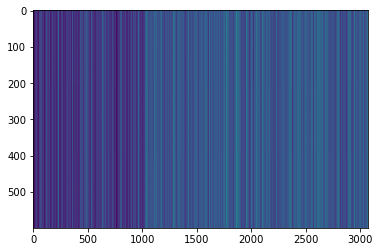

AUC      pAUC
Source_0  0.376000  0.483684
Source_1  0.555000  0.495263
Source_2  0.524400  0.518947
Target_0  0.617300  0.570000
Target_1  0.493500  0.492105
Target_2  0.505500  0.501579
mean      0.511950  0.510263
h_mean    0.500298  0.508744

2021-04-26 16:16:58,994 - pytorch_modeler.py - INFO - epoch:1/300, train_losses:52.806135, val_AUC_hmean:0.500298, val_pAUC_hmean:0.508744, best_flag:True
2021-04-26 16:16:58,995 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  5.18it/s]
2021-04-26 16:16:59,384 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.44it/s]
2021-04-26 16:16:59,540 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.69it/s]
2021-04-26 16:16:59,693 - pytorch_modeler.py - INFO - epoch:2/300, train_losses:15.648485, val_AUC_hmean:0.308787, val_pAUC_hmean:0.490070, best_flag:False
2021-04-26 16:16:59,694 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  4.93it/s]
2021-04-26 16:17:00,101 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.20it/s]
2021-04-26 16:17:00,261 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.33it/s]
2021-04-26 16:17:00,420 -

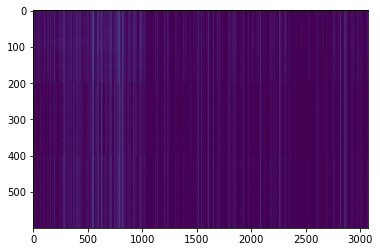

AUC      pAUC
Source_0  0.336800  0.517895
Source_1  0.384200  0.476316
Source_2  0.537800  0.496842
Target_0  0.608300  0.619474
Target_1  0.447500  0.497368
Target_2  0.527100  0.538947
mean      0.473617  0.524474
h_mean    0.454301  0.520681

2021-04-26 16:17:07,844 - pytorch_modeler.py - INFO - epoch:12/300, train_losses:0.760460, val_AUC_hmean:0.454301, val_pAUC_hmean:0.520681, best_flag:True
2021-04-26 16:17:07,845 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  3.79it/s]
2021-04-26 16:17:08,375 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.26it/s]
2021-04-26 16:17:08,534 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.57it/s]


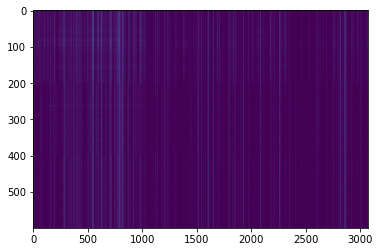

AUC      pAUC
Source_0  0.448700  0.573158
Source_1  0.402300  0.482632
Source_2  0.569900  0.493684
Target_0  0.715500  0.666316
Target_1  0.459200  0.495263
Target_2  0.555700  0.533684
mean      0.525217  0.540789
h_mean    0.506589  0.533999

2021-04-26 16:17:09,639 - pytorch_modeler.py - INFO - epoch:13/300, train_losses:0.655905, val_AUC_hmean:0.506589, val_pAUC_hmean:0.533999, best_flag:True
2021-04-26 16:17:09,640 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  4.00it/s]
2021-04-26 16:17:10,142 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  6.01it/s]
2021-04-26 16:17:10,331 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  6.63it/s]


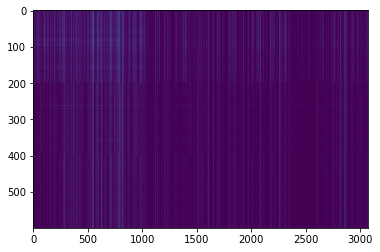

AUC      pAUC
Source_0  0.511900  0.596842
Source_1  0.450100  0.488947
Source_2  0.459400  0.503684
Target_0  0.779500  0.654211
Target_1  0.474200  0.500000
Target_2  0.524700  0.523158
mean      0.533300  0.544474
h_mean    0.515042  0.538305

2021-04-26 16:17:11,428 - pytorch_modeler.py - INFO - epoch:14/300, train_losses:0.584049, val_AUC_hmean:0.515042, val_pAUC_hmean:0.538305, best_flag:True
2021-04-26 16:17:11,430 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  3.70it/s]
2021-04-26 16:17:11,972 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  6.88it/s]
2021-04-26 16:17:12,138 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.14it/s]


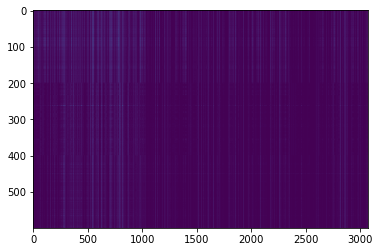

AUC      pAUC
Source_0  0.545400  0.611053
Source_1  0.487700  0.496316
Source_2  0.446900  0.511053
Target_0  0.821800  0.653684
Target_1  0.497200  0.496842
Target_2  0.502200  0.508947
mean      0.550200  0.546316
h_mean    0.529057  0.539789

2021-04-26 16:17:13,250 - pytorch_modeler.py - INFO - epoch:15/300, train_losses:0.521633, val_AUC_hmean:0.529057, val_pAUC_hmean:0.539789, best_flag:True
2021-04-26 16:17:13,250 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  3.77it/s]
2021-04-26 16:17:13,784 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.13it/s]
2021-04-26 16:17:13,948 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  6.47it/s]
2021-04-26 16:17:14,127 - pytorch_modeler.py - INFO - epoch:16/300, train_losses:0.482177, val_AUC_hmean:0.542988, val_pAUC_hmean:0.537290, best_flag:False
2021-04-26 16:17:14,129 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  3.90it/s]
2021-04-26 16:17:14,644 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.64it/s]
2021-04-26 16:17:14,794 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.62it/s]
2021-04-26 16:17:14,948 -

100%|██████████| 1/1 [00:00<00:00,  7.44it/s]
2021-04-26 16:17:27,825 - pytorch_modeler.py - INFO - epoch:32/300, train_losses:0.281235, val_AUC_hmean:0.520415, val_pAUC_hmean:0.522232, best_flag:False
2021-04-26 16:17:27,826 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  3.92it/s]
2021-04-26 16:17:28,339 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  6.59it/s]
2021-04-26 16:17:28,512 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.23it/s]
2021-04-26 16:17:28,674 - pytorch_modeler.py - INFO - epoch:33/300, train_losses:0.279079, val_AUC_hmean:0.513654, val_pAUC_hmean:0.521280, best_flag:False
2021-04-26 16:17:28,675 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  3.67it/s]
2021-04-26 16:17:29,222 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  6.46it/s]
2021-04-26 16:17:29,399 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00

100%|██████████| 1/1 [00:00<00:00,  7.11it/s]
2021-04-26 16:17:42,384 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.18it/s]
2021-04-26 16:17:42,548 - pytorch_modeler.py - INFO - epoch:49/300, train_losses:0.246786, val_AUC_hmean:0.557132, val_pAUC_hmean:0.526335, best_flag:False
2021-04-26 16:17:42,550 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  3.47it/s]
2021-04-26 16:17:43,129 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.51it/s]
2021-04-26 16:17:43,281 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  6.87it/s]
2021-04-26 16:17:43,448 - pytorch_modeler.py - INFO - epoch:50/300, train_losses:0.242795, val_AUC_hmean:0.569626, val_pAUC_hmean:0.526691, best_flag:False
2021-04-26 16:17:43,450 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  3.88it/s]
2021-04-26 16:17:43,968 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00

100%|██████████| 2/2 [00:00<00:00,  3.67it/s]
2021-04-26 16:17:57,083 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  6.68it/s]
2021-04-26 16:17:57,254 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.10it/s]
2021-04-26 16:17:57,418 - pytorch_modeler.py - INFO - epoch:66/300, train_losses:0.222000, val_AUC_hmean:0.589068, val_pAUC_hmean:0.533301, best_flag:False
2021-04-26 16:17:57,419 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  3.64it/s]
2021-04-26 16:17:57,971 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  6.98it/s]
2021-04-26 16:17:58,135 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.13it/s]
2021-04-26 16:17:58,297 - pytorch_modeler.py - INFO - epoch:67/300, train_losses:0.221776, val_AUC_hmean:0.582009, val_pAUC_hmean:0.531859, best_flag:False
2021-04-26 16:17:58,299 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00

2021-04-26 16:18:11,097 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  3.88it/s]
2021-04-26 16:18:11,614 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.56it/s]
2021-04-26 16:18:11,768 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.27it/s]
2021-04-26 16:18:11,928 - pytorch_modeler.py - INFO - epoch:83/300, train_losses:0.201590, val_AUC_hmean:0.605124, val_pAUC_hmean:0.539378, best_flag:False
2021-04-26 16:18:11,929 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  3.92it/s]
2021-04-26 16:18:12,441 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  6.91it/s]
2021-04-26 16:18:12,606 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.29it/s]
2021-04-26 16:18:12,767 - pytorch_modeler.py - INFO - epoch:84/300, train_losses:0.206840, val_AUC_hmean:0.594448, val_pAUC_hmean:0.532684, best_flag:False
2021-04-26 16:18:12,768 

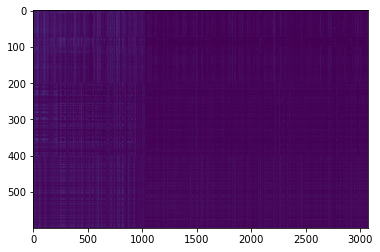

AUC      pAUC
Source_0  0.559000  0.522105
Source_1  0.514300  0.506316
Source_2  0.568700  0.508947
Target_0  0.858800  0.710000
Target_1  0.493700  0.493158
Target_2  0.618200  0.551053
mean      0.602117  0.548596
h_mean    0.582568  0.540243

2021-04-26 16:18:17,087 - pytorch_modeler.py - INFO - epoch:88/300, train_losses:0.230480, val_AUC_hmean:0.582568, val_pAUC_hmean:0.540243, best_flag:True
2021-04-26 16:18:17,088 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  3.89it/s]
2021-04-26 16:18:17,604 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.55it/s]
2021-04-26 16:18:17,757 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.59it/s]
2021-04-26 16:18:17,914 - pytorch_modeler.py - INFO - epoch:89/300, train_losses:0.242013, val_AUC_hmean:0.543994, val_pAUC_hmean:0.537464, best_flag:False
2021-04-26 16:18:17,915 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  3.88it/s]
2021-04-26 16:18:18,434 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.21it/s]
2021-04-26 16:18:18,595 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.40it/s]
2021-04-26 16:18:18,753 -

100%|██████████| 1/1 [00:00<00:00,  7.16it/s]
2021-04-26 16:18:31,385 - pytorch_modeler.py - INFO - epoch:105/300, train_losses:0.195665, val_AUC_hmean:0.596713, val_pAUC_hmean:0.534439, best_flag:False
2021-04-26 16:18:31,386 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  3.58it/s]
2021-04-26 16:18:31,947 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.33it/s]
2021-04-26 16:18:32,104 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.28it/s]
2021-04-26 16:18:32,266 - pytorch_modeler.py - INFO - epoch:106/300, train_losses:0.192486, val_AUC_hmean:0.599149, val_pAUC_hmean:0.530924, best_flag:False
2021-04-26 16:18:32,267 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  3.77it/s]
2021-04-26 16:18:32,801 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.65it/s]
2021-04-26 16:18:32,952 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [

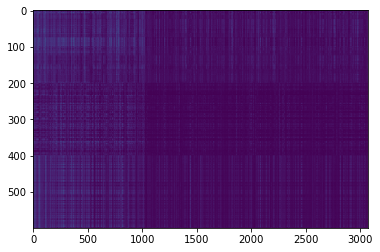

AUC      pAUC
Source_0  0.712700  0.576842
Source_1  0.542400  0.525263
Source_2  0.587400  0.488947
Target_0  0.816500  0.682105
Target_1  0.497400  0.487368
Target_2  0.602900  0.531579
mean      0.626550  0.548684
h_mean    0.609568  0.541435

2021-04-26 16:18:43,357 - pytorch_modeler.py - INFO - epoch:118/300, train_losses:0.179742, val_AUC_hmean:0.609568, val_pAUC_hmean:0.541435, best_flag:True
2021-04-26 16:18:43,357 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  3.75it/s]
2021-04-26 16:18:43,894 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.07it/s]
2021-04-26 16:18:44,055 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.56it/s]


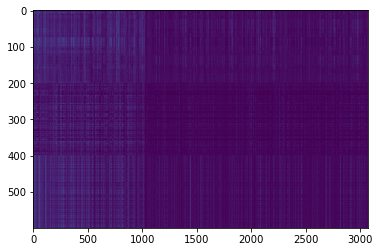

AUC      pAUC
Source_0  0.77160  0.591053
Source_1  0.53770  0.519474
Source_2  0.60690  0.488947
Target_0  0.82860  0.692105
Target_1  0.49250  0.486842
Target_2  0.60570  0.532632
mean      0.64050  0.551842
h_mean    0.61908  0.543551

2021-04-26 16:18:45,131 - pytorch_modeler.py - INFO - epoch:119/300, train_losses:0.179790, val_AUC_hmean:0.619080, val_pAUC_hmean:0.543551, best_flag:True
2021-04-26 16:18:45,132 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  3.65it/s]
2021-04-26 16:18:45,681 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  3.85it/s]
2021-04-26 16:18:45,962 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


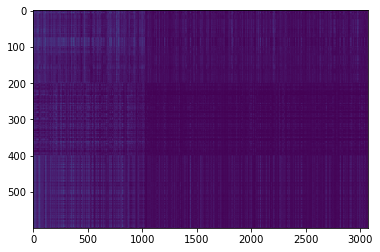

AUC      pAUC
Source_0  0.781400  0.587368
Source_1  0.543100  0.522105
Source_2  0.590700  0.489474
Target_0  0.847700  0.696842
Target_1  0.497100  0.486842
Target_2  0.608500  0.534737
mean      0.644750  0.552895
h_mean    0.621848  0.544464

2021-04-26 16:18:47,209 - pytorch_modeler.py - INFO - epoch:120/300, train_losses:0.178368, val_AUC_hmean:0.621848, val_pAUC_hmean:0.544464, best_flag:True
2021-04-26 16:18:47,210 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  4.99it/s]
2021-04-26 16:18:47,613 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  6.50it/s]
2021-04-26 16:18:47,790 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.57it/s]
2021-04-26 16:18:47,946 - pytorch_modeler.py - INFO - epoch:121/300, train_losses:0.176713, val_AUC_hmean:0.611115, val_pAUC_hmean:0.540862, best_flag:False
2021-04-26 16:18:47,947 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  5.09it/s]
2021-04-26 16:18:48,342 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.85it/s]
2021-04-26 16:18:48,491 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.66it/s]
2021-04-26 16:18:48,645

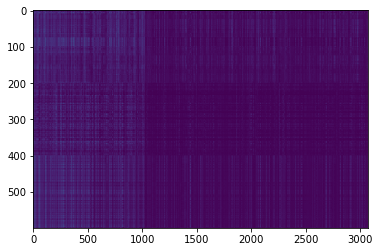

AUC      pAUC
Source_0  0.743100  0.605263
Source_1  0.552900  0.518421
Source_2  0.588600  0.488421
Target_0  0.831100  0.692105
Target_1  0.492600  0.487368
Target_2  0.601700  0.537895
mean      0.635000  0.554912
h_mean    0.615477  0.546233

2021-04-26 16:18:54,599 - pytorch_modeler.py - INFO - epoch:129/300, train_losses:0.171192, val_AUC_hmean:0.615477, val_pAUC_hmean:0.546233, best_flag:True
2021-04-26 16:18:54,600 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  5.05it/s]
2021-04-26 16:18:54,998 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.70it/s]
2021-04-26 16:18:55,147 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.63it/s]
2021-04-26 16:18:55,302 - pytorch_modeler.py - INFO - epoch:130/300, train_losses:0.171050, val_AUC_hmean:0.621329, val_pAUC_hmean:0.541362, best_flag:False
2021-04-26 16:18:55,303 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  4.79it/s]
2021-04-26 16:18:55,723 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.41it/s]
2021-04-26 16:18:55,878 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.58it/s]
2021-04-26 16:18:56,030

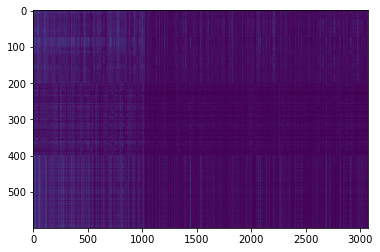

AUC      pAUC
Source_0  0.778600  0.613158
Source_1  0.553500  0.522105
Source_2  0.619900  0.486316
Target_0  0.811100  0.686316
Target_1  0.492400  0.489474
Target_2  0.602500  0.539474
mean      0.643000  0.556140
h_mean    0.623201  0.547634

2021-04-26 16:19:01,191 - pytorch_modeler.py - INFO - epoch:137/300, train_losses:0.163457, val_AUC_hmean:0.623201, val_pAUC_hmean:0.547634, best_flag:True
2021-04-26 16:19:01,191 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  4.88it/s]
2021-04-26 16:19:01,603 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.62it/s]
2021-04-26 16:19:01,754 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.73it/s]
2021-04-26 16:19:01,905 - pytorch_modeler.py - INFO - epoch:138/300, train_losses:0.165157, val_AUC_hmean:0.620766, val_pAUC_hmean:0.545594, best_flag:False
2021-04-26 16:19:01,907 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  4.78it/s]
2021-04-26 16:19:02,328 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.83it/s]
2021-04-26 16:19:02,475 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.83it/s]
2021-04-26 16:19:02,628

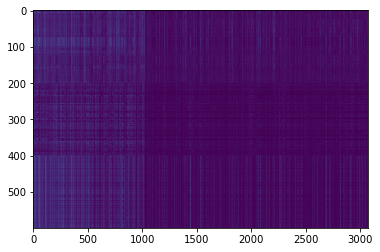

AUC      pAUC
Source_0  0.813500  0.671053
Source_1  0.537100  0.511579
Source_2  0.598700  0.487895
Target_0  0.834100  0.695789
Target_1  0.488800  0.490000
Target_2  0.611700  0.537368
mean      0.647317  0.565614
h_mean    0.622348  0.553837

2021-04-26 16:19:04,241 - pytorch_modeler.py - INFO - epoch:140/300, train_losses:0.163835, val_AUC_hmean:0.622348, val_pAUC_hmean:0.553837, best_flag:True
2021-04-26 16:19:04,242 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  4.99it/s]
2021-04-26 16:19:04,644 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.68it/s]
2021-04-26 16:19:04,795 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.36it/s]
2021-04-26 16:19:04,956 - pytorch_modeler.py - INFO - epoch:141/300, train_losses:0.162568, val_AUC_hmean:0.619048, val_pAUC_hmean:0.550094, best_flag:False
2021-04-26 16:19:04,957 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  4.25it/s]
2021-04-26 16:19:05,430 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  6.48it/s]
2021-04-26 16:19:05,605 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  6.86it/s]
2021-04-26 16:19:05,777

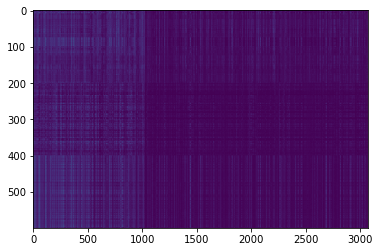

AUC      pAUC
Source_0  0.820400  0.663158
Source_1  0.546300  0.517895
Source_2  0.617000  0.488947
Target_0  0.845100  0.699474
Target_1  0.492300  0.490000
Target_2  0.610800  0.538947
mean      0.655317  0.566404
h_mean    0.630124  0.555043

2021-04-26 16:19:11,255 - pytorch_modeler.py - INFO - epoch:148/300, train_losses:0.156658, val_AUC_hmean:0.630124, val_pAUC_hmean:0.555043, best_flag:True
2021-04-26 16:19:11,256 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  4.82it/s]
2021-04-26 16:19:11,673 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.00it/s]
2021-04-26 16:19:11,836 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.35it/s]
2021-04-26 16:19:11,994 - pytorch_modeler.py - INFO - epoch:149/300, train_losses:0.156711, val_AUC_hmean:0.626362, val_pAUC_hmean:0.549828, best_flag:False
2021-04-26 16:19:11,995 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  5.01it/s]
2021-04-26 16:19:12,396 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.35it/s]
2021-04-26 16:19:12,552 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.63it/s]


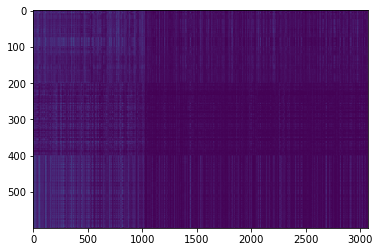

AUC      pAUC
Source_0  0.832300  0.674737
Source_1  0.545700  0.513158
Source_2  0.611900  0.497895
Target_0  0.831100  0.690000
Target_1  0.487500  0.488421
Target_2  0.612000  0.538421
mean      0.653417  0.567105
h_mean    0.627829  0.555905

2021-04-26 16:19:13,617 - pytorch_modeler.py - INFO - epoch:150/300, train_losses:0.155854, val_AUC_hmean:0.627829, val_pAUC_hmean:0.555905, best_flag:True
2021-04-26 16:19:13,618 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  5.00it/s]
2021-04-26 16:19:14,021 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.38it/s]
2021-04-26 16:19:14,176 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.05it/s]
2021-04-26 16:19:14,340 - pytorch_modeler.py - INFO - epoch:151/300, train_losses:0.155393, val_AUC_hmean:0.624956, val_pAUC_hmean:0.549855, best_flag:False
2021-04-26 16:19:14,341 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  4.66it/s]
2021-04-26 16:19:14,773 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  6.44it/s]
2021-04-26 16:19:14,950 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  5.94it/s]
2021-04-26 16:19:15,144

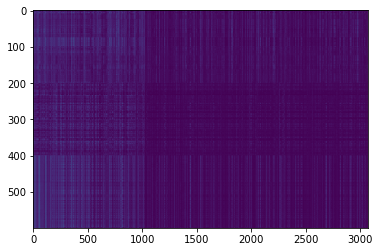

AUC      pAUC
Source_0  0.794100  0.672105
Source_1  0.550100  0.515263
Source_2  0.618900  0.494737
Target_0  0.838900  0.693684
Target_1  0.488600  0.487895
Target_2  0.614700  0.540000
mean      0.650883  0.567281
h_mean    0.627719  0.555919

2021-04-26 16:19:17,661 - pytorch_modeler.py - INFO - epoch:154/300, train_losses:0.153669, val_AUC_hmean:0.627719, val_pAUC_hmean:0.555919, best_flag:True
2021-04-26 16:19:17,662 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  4.93it/s]
2021-04-26 16:19:18,070 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  6.69it/s]
2021-04-26 16:19:18,240 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.71it/s]
2021-04-26 16:19:18,392 - pytorch_modeler.py - INFO - epoch:155/300, train_losses:0.153674, val_AUC_hmean:0.614414, val_pAUC_hmean:0.543763, best_flag:False
2021-04-26 16:19:18,393 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  5.00it/s]
2021-04-26 16:19:18,795 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.48it/s]
2021-04-26 16:19:18,948 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.22it/s]
2021-04-26 16:19:19,109

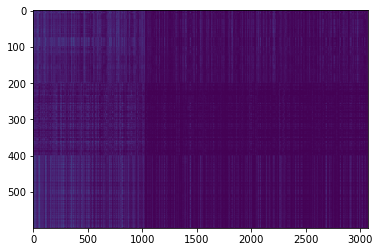

AUC      pAUC
Source_0  0.861800  0.695263
Source_1  0.560800  0.519474
Source_2  0.610300  0.487368
Target_0  0.819300  0.690000
Target_1  0.490700  0.491579
Target_2  0.609700  0.540000
mean      0.658767  0.570614
h_mean    0.632866  0.558111

2021-04-26 16:19:22,250 - pytorch_modeler.py - INFO - epoch:159/300, train_losses:0.150323, val_AUC_hmean:0.632866, val_pAUC_hmean:0.558111, best_flag:True
2021-04-26 16:19:22,251 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  4.62it/s]
2021-04-26 16:19:22,686 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.66it/s]
2021-04-26 16:19:22,837 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.19it/s]
2021-04-26 16:19:22,998 - pytorch_modeler.py - INFO - epoch:160/300, train_losses:0.149794, val_AUC_hmean:0.628476, val_pAUC_hmean:0.552046, best_flag:False
2021-04-26 16:19:22,999 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  4.78it/s]
2021-04-26 16:19:23,420 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.17it/s]
2021-04-26 16:19:23,581 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.60it/s]
2021-04-26 16:19:23,733

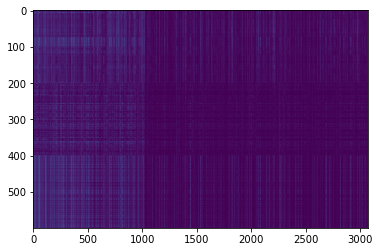

AUC      pAUC
Source_0  0.863900  0.738947
Source_1  0.559300  0.520526
Source_2  0.621800  0.493684
Target_0  0.829200  0.694737
Target_1  0.487500  0.490526
Target_2  0.609500  0.543158
mean      0.661867  0.580263
h_mean    0.634808  0.565020

2021-04-26 16:19:32,858 - pytorch_modeler.py - INFO - epoch:172/300, train_losses:0.143194, val_AUC_hmean:0.634808, val_pAUC_hmean:0.565020, best_flag:True
2021-04-26 16:19:32,859 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  4.51it/s]
2021-04-26 16:19:33,305 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.13it/s]
2021-04-26 16:19:33,466 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  6.66it/s]
2021-04-26 16:19:33,640 - pytorch_modeler.py - INFO - epoch:173/300, train_losses:0.142401, val_AUC_hmean:0.631818, val_pAUC_hmean:0.557837, best_flag:False
2021-04-26 16:19:33,641 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  4.86it/s]
2021-04-26 16:19:34,055 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.55it/s]
2021-04-26 16:19:34,207 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.47it/s]
2021-04-26 16:19:34,365

100%|██████████| 1/1 [00:00<00:00,  7.56it/s]
2021-04-26 16:19:45,128 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  6.69it/s]
2021-04-26 16:19:45,299 - pytorch_modeler.py - INFO - epoch:189/300, train_losses:0.136635, val_AUC_hmean:0.637701, val_pAUC_hmean:0.556686, best_flag:False
2021-04-26 16:19:45,300 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  4.94it/s]
2021-04-26 16:19:45,707 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.75it/s]
2021-04-26 16:19:45,855 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  6.83it/s]
2021-04-26 16:19:46,025 - pytorch_modeler.py - INFO - epoch:190/300, train_losses:0.134461, val_AUC_hmean:0.631643, val_pAUC_hmean:0.556235, best_flag:False
2021-04-26 16:19:46,026 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  4.91it/s]
2021-04-26 16:19:46,436 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [

100%|██████████| 2/2 [00:00<00:00,  4.92it/s]
2021-04-26 16:19:57,613 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  6.92it/s]
2021-04-26 16:19:57,779 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  6.84it/s]
2021-04-26 16:19:57,947 - pytorch_modeler.py - INFO - epoch:206/300, train_losses:0.128038, val_AUC_hmean:0.645655, val_pAUC_hmean:0.558493, best_flag:False
2021-04-26 16:19:57,948 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  4.98it/s]
2021-04-26 16:19:58,353 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.42it/s]
2021-04-26 16:19:58,507 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.48it/s]
2021-04-26 16:19:58,663 - pytorch_modeler.py - INFO - epoch:207/300, train_losses:0.127161, val_AUC_hmean:0.645620, val_pAUC_hmean:0.560159, best_flag:False
2021-04-26 16:19:58,664 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [

2021-04-26 16:20:09,591 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  5.07it/s]
2021-04-26 16:20:09,987 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.34it/s]
2021-04-26 16:20:10,144 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  6.98it/s]
2021-04-26 16:20:10,311 - pytorch_modeler.py - INFO - epoch:223/300, train_losses:0.121454, val_AUC_hmean:0.630079, val_pAUC_hmean:0.542966, best_flag:False
2021-04-26 16:20:10,312 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  4.85it/s]
2021-04-26 16:20:10,728 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.62it/s]
2021-04-26 16:20:10,878 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  6.96it/s]
2021-04-26 16:20:11,045 - pytorch_modeler.py - INFO - epoch:224/300, train_losses:0.120206, val_AUC_hmean:0.637195, val_pAUC_hmean:0.551390, best_flag:False
2021-04-26 16:20:11,04

2021-04-26 16:20:22,355 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  5.09it/s]
2021-04-26 16:20:22,751 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.66it/s]
2021-04-26 16:20:22,900 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.45it/s]
2021-04-26 16:20:23,058 - pytorch_modeler.py - INFO - epoch:240/300, train_losses:0.112612, val_AUC_hmean:0.652024, val_pAUC_hmean:0.558286, best_flag:False
2021-04-26 16:20:23,059 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  5.03it/s]
2021-04-26 16:20:23,459 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.57it/s]
2021-04-26 16:20:23,610 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.57it/s]
2021-04-26 16:20:23,765 - pytorch_modeler.py - INFO - epoch:241/300, train_losses:0.113678, val_AUC_hmean:0.651026, val_pAUC_hmean:0.551815, best_flag:False
2021-04-26 16:20:23,76

2021-04-26 16:20:34,797 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  4.53it/s]
2021-04-26 16:20:35,240 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  6.52it/s]
2021-04-26 16:20:35,415 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  6.98it/s]
2021-04-26 16:20:35,582 - pytorch_modeler.py - INFO - epoch:257/300, train_losses:0.106769, val_AUC_hmean:0.644291, val_pAUC_hmean:0.559155, best_flag:False
2021-04-26 16:20:35,583 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  4.67it/s]
2021-04-26 16:20:36,014 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  6.94it/s]
2021-04-26 16:20:36,179 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.11it/s]
2021-04-26 16:20:36,344 - pytorch_modeler.py - INFO - epoch:258/300, train_losses:0.106840, val_AUC_hmean:0.642227, val_pAUC_hmean:0.557293, best_flag:False
2021-04-26 16:20:36,34

2021-04-26 16:20:47,016 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  4.96it/s]
2021-04-26 16:20:47,422 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.59it/s]
2021-04-26 16:20:47,574 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.43it/s]
2021-04-26 16:20:47,731 - pytorch_modeler.py - INFO - epoch:274/300, train_losses:0.100737, val_AUC_hmean:0.641052, val_pAUC_hmean:0.551793, best_flag:False
2021-04-26 16:20:47,732 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  5.04it/s]
2021-04-26 16:20:48,131 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.69it/s]
2021-04-26 16:20:48,280 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.35it/s]


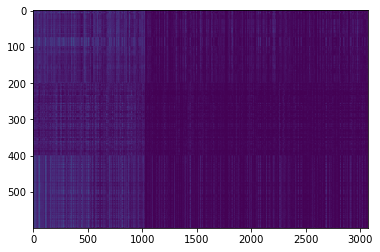

AUC      pAUC
Source_0  0.886200  0.733158
Source_1  0.581900  0.523684
Source_2  0.655900  0.495263
Target_0  0.830300  0.697368
Target_1  0.505900  0.490526
Target_2  0.609100  0.544211
mean      0.678217  0.580702
h_mean    0.652573  0.565891

2021-04-26 16:20:49,337 - pytorch_modeler.py - INFO - epoch:275/300, train_losses:0.101967, val_AUC_hmean:0.652573, val_pAUC_hmean:0.565891, best_flag:True
2021-04-26 16:20:49,338 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  5.19it/s]
2021-04-26 16:20:49,725 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.82it/s]
2021-04-26 16:20:49,872 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.73it/s]
2021-04-26 16:20:50,023 - pytorch_modeler.py - INFO - epoch:276/300, train_losses:0.101331, val_AUC_hmean:0.647074, val_pAUC_hmean:0.557128, best_flag:False
2021-04-26 16:20:50,024 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  5.03it/s]
2021-04-26 16:20:50,424 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.44it/s]
2021-04-26 16:20:50,577 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.62it/s]
2021-04-26 16:20:50,731

100%|██████████| 1/1 [00:00<00:00,  7.19it/s]
2021-04-26 16:21:01,542 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  6.63it/s]
2021-04-26 16:21:01,714 - pytorch_modeler.py - INFO - epoch:292/300, train_losses:0.096613, val_AUC_hmean:0.661253, val_pAUC_hmean:0.564823, best_flag:False
2021-04-26 16:21:01,715 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  5.14it/s]
2021-04-26 16:21:02,106 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.32it/s]
2021-04-26 16:21:02,262 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.09it/s]
2021-04-26 16:21:02,425 - pytorch_modeler.py - INFO - epoch:293/300, train_losses:0.096799, val_AUC_hmean:0.652473, val_pAUC_hmean:0.559112, best_flag:False
2021-04-26 16:21:02,426 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  4.94it/s]
2021-04-26 16:21:02,833 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [

AUC      pAUC
Source_0  0.886200  0.733158
Source_1  0.581900  0.523684
Source_2  0.655900  0.495263
Target_0  0.830300  0.697368
Target_1  0.505900  0.490526
Target_2  0.609100  0.544211
mean      0.678217  0.580702
h_mean    0.652573  0.565891

2021-04-26 16:21:07,526 - 00_train.py - INFO - TARGET MACHINE_TYPE: pump
2021-04-26 16:21:07,527 - 00_train.py - INFO - MAKE DATA_LOADER


elapsed time: 250.350145578 [sec]


2021-04-26 16:21:08,043 - 00_train.py - INFO - TRAINING
2021-04-26 16:21:08,264 - pytorch_modeler.py - INFO - train
  0%|          | 0/2 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 2/2 [00:00<00:00,  4.48it/s]
2021-04-26 16:21:08,713 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  6.97it/s]
2021-04-26 16:21:08,876 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.14it/s]


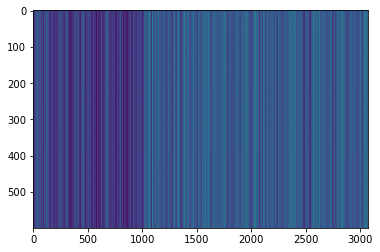

AUC      pAUC
Source_0  0.386000  0.502105
Source_1  0.471700  0.493684
Source_2  0.511900  0.516316
Target_0  0.478500  0.500000
Target_1  0.533200  0.503158
Target_2  0.507300  0.505789
mean      0.481433  0.503509
h_mean    0.476163  0.503417

2021-04-26 16:21:09,931 - pytorch_modeler.py - INFO - epoch:1/300, train_losses:52.006367, val_AUC_hmean:0.476163, val_pAUC_hmean:0.503417, best_flag:True
2021-04-26 16:21:09,932 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  5.11it/s]
2021-04-26 16:21:10,325 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.12it/s]
2021-04-26 16:21:10,486 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.31it/s]
2021-04-26 16:21:10,646 - pytorch_modeler.py - INFO - epoch:2/300, train_losses:15.130834, val_AUC_hmean:0.482199, val_pAUC_hmean:0.501178, best_flag:False
2021-04-26 16:21:10,648 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  5.21it/s]
2021-04-26 16:21:11,034 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.57it/s]
2021-04-26 16:21:11,186 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.67it/s]
2021-04-26 16:21:11,338 -

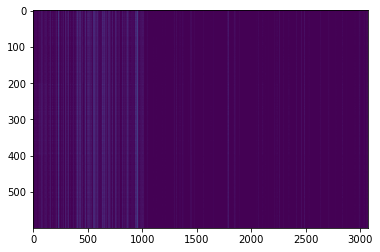

AUC      pAUC
Source_0  0.418200  0.500526
Source_1  0.456600  0.488947
Source_2  0.519900  0.528421
Target_0  0.428400  0.500000
Target_1  0.538500  0.495789
Target_2  0.534900  0.511579
mean      0.482750  0.504211
h_mean    0.477497  0.503894

2021-04-26 16:21:14,353 - pytorch_modeler.py - INFO - epoch:6/300, train_losses:2.278357, val_AUC_hmean:0.477497, val_pAUC_hmean:0.503894, best_flag:True
2021-04-26 16:21:14,353 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  5.21it/s]
2021-04-26 16:21:14,740 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.60it/s]
2021-04-26 16:21:14,891 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.35it/s]
2021-04-26 16:21:15,051 - pytorch_modeler.py - INFO - epoch:7/300, train_losses:1.686068, val_AUC_hmean:0.471772, val_pAUC_hmean:0.499768, best_flag:False
2021-04-26 16:21:15,052 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  5.15it/s]
2021-04-26 16:21:15,442 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  6.90it/s]
2021-04-26 16:21:15,607 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.06it/s]
2021-04-26 16:21:15,769 - p

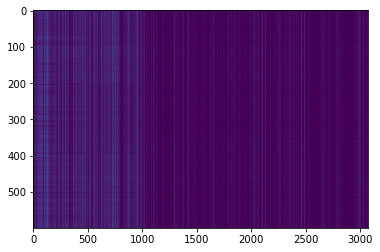

AUC      pAUC
Source_0  0.584500  0.504211
Source_1  0.492700  0.483158
Source_2  0.517900  0.515789
Target_0  0.608000  0.527368
Target_1  0.412400  0.502632
Target_2  0.480500  0.493684
mean      0.516000  0.504474
h_mean    0.507524  0.504070

2021-04-26 16:21:22,061 - pytorch_modeler.py - INFO - epoch:15/300, train_losses:0.593366, val_AUC_hmean:0.507524, val_pAUC_hmean:0.504070, best_flag:True
2021-04-26 16:21:22,062 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  4.46it/s]
2021-04-26 16:21:22,512 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.47it/s]
2021-04-26 16:21:22,665 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.56it/s]


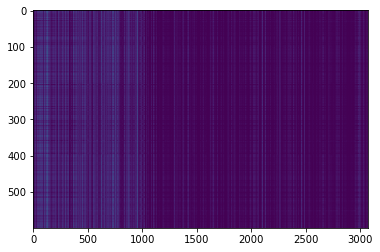

AUC      pAUC
Source_0  0.586000  0.507368
Source_1  0.494400  0.487895
Source_2  0.515700  0.511579
Target_0  0.607400  0.528947
Target_1  0.412700  0.502632
Target_2  0.481900  0.494211
mean      0.516350  0.505439
h_mean    0.507924  0.505101

2021-04-26 16:21:23,730 - pytorch_modeler.py - INFO - epoch:16/300, train_losses:0.520860, val_AUC_hmean:0.507924, val_pAUC_hmean:0.505101, best_flag:True
2021-04-26 16:21:23,730 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  5.12it/s]
2021-04-26 16:21:24,123 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.25it/s]
2021-04-26 16:21:24,280 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.51it/s]


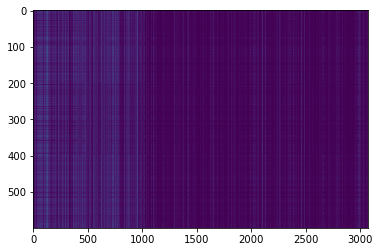

AUC      pAUC
Source_0  0.580600  0.507368
Source_1  0.496300  0.495263
Source_2  0.513000  0.507895
Target_0  0.612100  0.533158
Target_1  0.413300  0.498947
Target_2  0.483200  0.493158
mean      0.516417  0.505965
h_mean    0.508070  0.505622

2021-04-26 16:21:25,423 - pytorch_modeler.py - INFO - epoch:17/300, train_losses:0.496060, val_AUC_hmean:0.508070, val_pAUC_hmean:0.505622, best_flag:True
2021-04-26 16:21:25,424 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  4.89it/s]
2021-04-26 16:21:25,834 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.07it/s]
2021-04-26 16:21:25,996 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  6.55it/s]


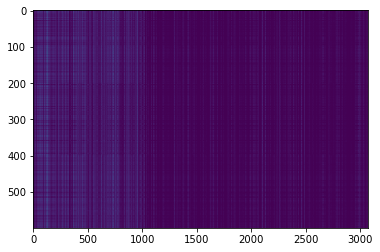

AUC      pAUC
Source_0  0.572300  0.511579
Source_1  0.494100  0.492105
Source_2  0.512600  0.517895
Target_0  0.614800  0.532105
Target_1  0.414200  0.497368
Target_2  0.481700  0.492632
mean      0.514950  0.507281
h_mean    0.506805  0.506862

2021-04-26 16:21:27,091 - pytorch_modeler.py - INFO - epoch:18/300, train_losses:0.451199, val_AUC_hmean:0.506805, val_pAUC_hmean:0.506862, best_flag:True
2021-04-26 16:21:27,092 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  3.84it/s]
2021-04-26 16:21:27,615 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.57it/s]
2021-04-26 16:21:27,766 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.22it/s]
2021-04-26 16:21:27,927 - pytorch_modeler.py - INFO - epoch:19/300, train_losses:0.427687, val_AUC_hmean:0.507273, val_pAUC_hmean:0.506110, best_flag:False
2021-04-26 16:21:27,928 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  3.93it/s]
2021-04-26 16:21:28,439 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.58it/s]
2021-04-26 16:21:28,590 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.63it/s]


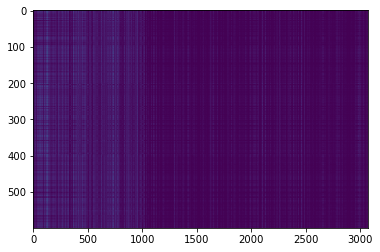

AUC      pAUC
Source_0  0.599700  0.551053
Source_1  0.487200  0.491579
Source_2  0.509000  0.521053
Target_0  0.613000  0.525789
Target_1  0.417700  0.491053
Target_2  0.475100  0.493158
mean      0.516950  0.512281
h_mean    0.507834  0.511324

2021-04-26 16:21:29,631 - pytorch_modeler.py - INFO - epoch:20/300, train_losses:0.408207, val_AUC_hmean:0.507834, val_pAUC_hmean:0.511324, best_flag:True
2021-04-26 16:21:29,632 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  3.91it/s]
2021-04-26 16:21:30,146 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.41it/s]
2021-04-26 16:21:30,300 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.05it/s]


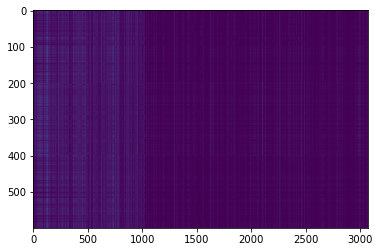

AUC      pAUC
Source_0  0.602200  0.585263
Source_1  0.483300  0.492105
Source_2  0.500700  0.520000
Target_0  0.607000  0.522105
Target_1  0.429300  0.491579
Target_2  0.468300  0.492105
mean      0.515133  0.517193
h_mean    0.506796  0.515222

2021-04-26 16:21:31,347 - pytorch_modeler.py - INFO - epoch:21/300, train_losses:0.400733, val_AUC_hmean:0.506796, val_pAUC_hmean:0.515222, best_flag:True
2021-04-26 16:21:31,348 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  3.81it/s]
2021-04-26 16:21:31,875 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.59it/s]
2021-04-26 16:21:32,025 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.34it/s]


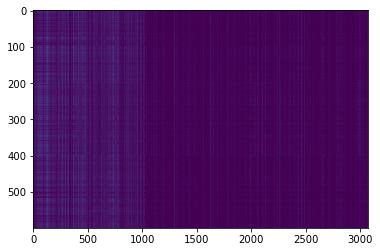

AUC      pAUC
Source_0  0.604000  0.603684
Source_1  0.482800  0.492632
Source_2  0.502900  0.525789
Target_0  0.605100  0.522632
Target_1  0.430300  0.490000
Target_2  0.464200  0.495789
mean      0.514883  0.521754
h_mean    0.506493  0.519053

2021-04-26 16:21:33,063 - pytorch_modeler.py - INFO - epoch:22/300, train_losses:0.387805, val_AUC_hmean:0.506493, val_pAUC_hmean:0.519053, best_flag:True
2021-04-26 16:21:33,064 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  3.82it/s]
2021-04-26 16:21:33,590 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.66it/s]
2021-04-26 16:21:33,740 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.52it/s]


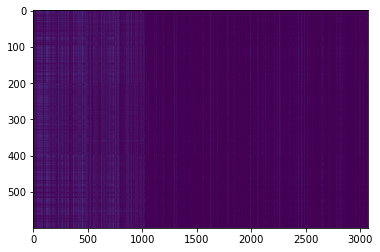

AUC      pAUC
Source_0  0.595600  0.612105
Source_1  0.487100  0.499474
Source_2  0.501700  0.534737
Target_0  0.596300  0.521579
Target_1  0.448500  0.491579
Target_2  0.458500  0.495789
mean      0.514617  0.525877
h_mean    0.507921  0.522903

2021-04-26 16:21:34,778 - pytorch_modeler.py - INFO - epoch:23/300, train_losses:0.377907, val_AUC_hmean:0.507921, val_pAUC_hmean:0.522903, best_flag:True
2021-04-26 16:21:34,779 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  3.83it/s]
2021-04-26 16:21:35,303 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.29it/s]
2021-04-26 16:21:35,461 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.35it/s]
2021-04-26 16:21:35,620 - pytorch_modeler.py - INFO - epoch:24/300, train_losses:0.378980, val_AUC_hmean:0.505125, val_pAUC_hmean:0.522506, best_flag:False
2021-04-26 16:21:35,621 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  3.84it/s]
2021-04-26 16:21:36,143 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.45it/s]
2021-04-26 16:21:36,296 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.45it/s]


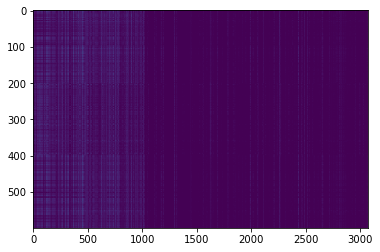

AUC      pAUC
Source_0  0.584600  0.612632
Source_1  0.486800  0.503158
Source_2  0.514400  0.534737
Target_0  0.593600  0.522105
Target_1  0.469300  0.493684
Target_2  0.454600  0.497895
mean      0.517217  0.527368
h_mean    0.511770  0.524512

2021-04-26 16:21:37,334 - pytorch_modeler.py - INFO - epoch:25/300, train_losses:0.357692, val_AUC_hmean:0.511770, val_pAUC_hmean:0.524512, best_flag:True
2021-04-26 16:21:37,335 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  3.80it/s]
2021-04-26 16:21:37,863 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  6.80it/s]
2021-04-26 16:21:38,029 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.41it/s]


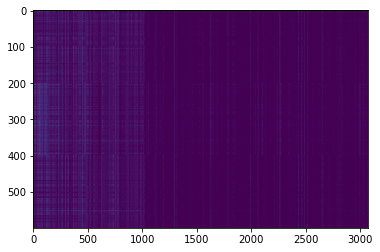

AUC      pAUC
Source_0  0.596300  0.622632
Source_1  0.485500  0.507368
Source_2  0.502600  0.540000
Target_0  0.588400  0.516316
Target_1  0.467600  0.495789
Target_2  0.454400  0.496842
mean      0.515800  0.529825
h_mean    0.509978  0.526529

2021-04-26 16:21:39,105 - pytorch_modeler.py - INFO - epoch:26/300, train_losses:0.349774, val_AUC_hmean:0.509978, val_pAUC_hmean:0.526529, best_flag:True
2021-04-26 16:21:39,106 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  3.66it/s]
2021-04-26 16:21:39,655 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  3.72it/s]
2021-04-26 16:21:39,943 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


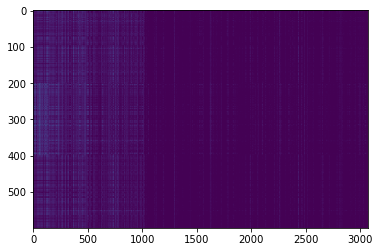

AUC      pAUC
Source_0  0.601900  0.630000
Source_1  0.497100  0.515263
Source_2  0.510400  0.538947
Target_0  0.595800  0.512632
Target_1  0.469400  0.491053
Target_2  0.453600  0.496842
mean      0.521367  0.530789
h_mean    0.515212  0.527083

2021-04-26 16:21:41,227 - pytorch_modeler.py - INFO - epoch:27/300, train_losses:0.343001, val_AUC_hmean:0.515212, val_pAUC_hmean:0.527083, best_flag:True
2021-04-26 16:21:41,228 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  4.78it/s]
2021-04-26 16:21:41,649 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  6.90it/s]
2021-04-26 16:21:41,814 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.33it/s]


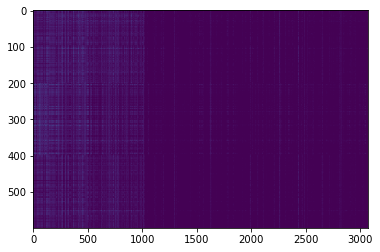

AUC      pAUC
Source_0  0.593800  0.628947
Source_1  0.503500  0.516316
Source_2  0.519800  0.539474
Target_0  0.590700  0.516316
Target_1  0.473700  0.490526
Target_2  0.447000  0.497368
mean      0.521417  0.531491
h_mean    0.515682  0.527871

2021-04-26 16:21:42,820 - pytorch_modeler.py - INFO - epoch:28/300, train_losses:0.339085, val_AUC_hmean:0.515682, val_pAUC_hmean:0.527871, best_flag:True
2021-04-26 16:21:42,820 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  4.80it/s]
2021-04-26 16:21:43,240 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.33it/s]
2021-04-26 16:21:43,396 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.40it/s]
2021-04-26 16:21:43,554 - pytorch_modeler.py - INFO - epoch:29/300, train_losses:0.335825, val_AUC_hmean:0.517064, val_pAUC_hmean:0.527645, best_flag:False
2021-04-26 16:21:43,556 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  5.02it/s]
2021-04-26 16:21:43,956 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.32it/s]
2021-04-26 16:21:44,113 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  6.83it/s]


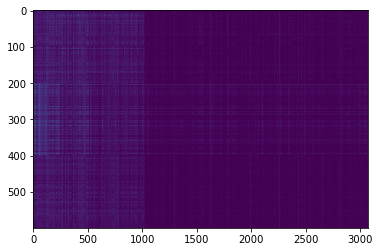

AUC      pAUC
Source_0  0.609600  0.626842
Source_1  0.505800  0.515789
Source_2  0.534700  0.551053
Target_0  0.589400  0.508947
Target_1  0.462800  0.488421
Target_2  0.450900  0.502632
mean      0.525533  0.532281
h_mean    0.518902  0.528608

2021-04-26 16:21:45,077 - pytorch_modeler.py - INFO - epoch:30/300, train_losses:0.325985, val_AUC_hmean:0.518902, val_pAUC_hmean:0.528608, best_flag:True
2021-04-26 16:21:45,078 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  5.08it/s]
2021-04-26 16:21:45,474 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.36it/s]
2021-04-26 16:21:45,628 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.07it/s]


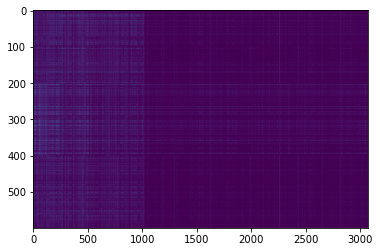

AUC      pAUC
Source_0  0.597100  0.633684
Source_1  0.515300  0.518421
Source_2  0.543700  0.553684
Target_0  0.574500  0.507895
Target_1  0.475400  0.487368
Target_2  0.449800  0.502105
mean      0.525967  0.533860
h_mean    0.520744  0.529780

2021-04-26 16:21:46,695 - pytorch_modeler.py - INFO - epoch:31/300, train_losses:0.323074, val_AUC_hmean:0.520744, val_pAUC_hmean:0.529780, best_flag:True
2021-04-26 16:21:46,695 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  4.80it/s]
2021-04-26 16:21:47,114 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  6.87it/s]
2021-04-26 16:21:47,279 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  6.74it/s]


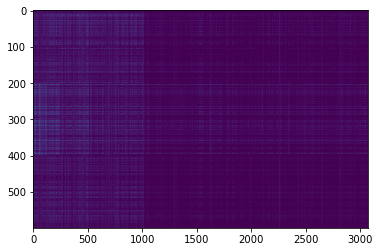

AUC      pAUC
Source_0  0.607400  0.636842
Source_1  0.519800  0.516316
Source_2  0.545700  0.566842
Target_0  0.556600  0.506316
Target_1  0.475600  0.486842
Target_2  0.453100  0.501579
mean      0.526367  0.535789
h_mean    0.521334  0.531255

2021-04-26 16:21:48,277 - pytorch_modeler.py - INFO - epoch:32/300, train_losses:0.318533, val_AUC_hmean:0.521334, val_pAUC_hmean:0.531255, best_flag:True
2021-04-26 16:21:48,278 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  4.83it/s]
2021-04-26 16:21:48,695 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.34it/s]
2021-04-26 16:21:48,850 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  6.93it/s]


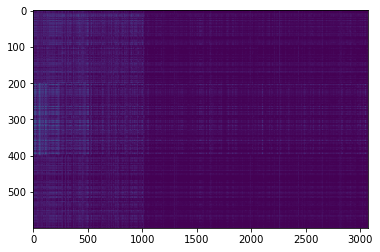

AUC      pAUC
Source_0  0.606600  0.631579
Source_1  0.520200  0.517895
Source_2  0.544500  0.566842
Target_0  0.562100  0.510000
Target_1  0.465300  0.487895
Target_2  0.457200  0.500526
mean      0.525983  0.535789
h_mean    0.520705  0.531600

2021-04-26 16:21:49,841 - pytorch_modeler.py - INFO - epoch:33/300, train_losses:0.313791, val_AUC_hmean:0.520705, val_pAUC_hmean:0.531600, best_flag:True
2021-04-26 16:21:49,842 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  4.73it/s]
2021-04-26 16:21:50,267 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.16it/s]
2021-04-26 16:21:50,425 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.34it/s]


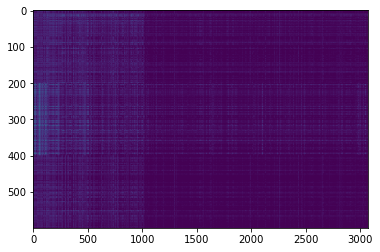

AUC      pAUC
Source_0  0.624300  0.637368
Source_1  0.504300  0.527368
Source_2  0.543600  0.562105
Target_0  0.565200  0.508947
Target_1  0.446900  0.486842
Target_2  0.458000  0.501053
mean      0.523717  0.537281
h_mean    0.516589  0.532913

2021-04-26 16:21:51,432 - pytorch_modeler.py - INFO - epoch:34/300, train_losses:0.311856, val_AUC_hmean:0.516589, val_pAUC_hmean:0.532913, best_flag:True
2021-04-26 16:21:51,433 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  4.79it/s]
2021-04-26 16:21:51,853 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.18it/s]
2021-04-26 16:21:52,013 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  6.46it/s]
2021-04-26 16:21:52,190 - pytorch_modeler.py - INFO - epoch:35/300, train_losses:0.308527, val_AUC_hmean:0.527253, val_pAUC_hmean:0.531717, best_flag:False
2021-04-26 16:21:52,191 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  4.82it/s]
2021-04-26 16:21:52,608 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.39it/s]
2021-04-26 16:21:52,763 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  7.15it/s]
2021-04-26 16:21:52,925 -

100%|██████████| 1/1 [00:00<00:00,  7.34it/s]
2021-04-26 16:22:04,304 - pytorch_modeler.py - INFO - epoch:51/300, train_losses:0.350375, val_AUC_hmean:0.524539, val_pAUC_hmean:0.526895, best_flag:False
2021-04-26 16:22:04,305 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  4.99it/s]
2021-04-26 16:22:04,708 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  7.05it/s]
2021-04-26 16:22:04,870 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00:00<00:00,  6.58it/s]
2021-04-26 16:22:05,046 - pytorch_modeler.py - INFO - epoch:52/300, train_losses:0.352995, val_AUC_hmean:0.529464, val_pAUC_hmean:0.527759, best_flag:False
2021-04-26 16:22:05,047 - pytorch_modeler.py - INFO - train
100%|██████████| 2/2 [00:00<00:00,  4.73it/s]
2021-04-26 16:22:05,472 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 1/1 [00:00<00:00,  6.95it/s]
2021-04-26 16:22:05,635 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 1/1 [00

KeyboardInterrupt: 

In [10]:
for machine_type in machine_types:
    run(machine_type)